# Kinematic analysis of J0923+01

Author: [Kiara Hervella](https://www.linkedin.com/in/kiara-hervella/)

## Initialisation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('tab10',8)
sns.set_style('whitegrid')
import numpy as np

from astropy.modeling import models, fitting
from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(H0=70,Om0=0.3)
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from specutils.analysis import line_flux

import astropy.units as u
from astropy.table import QTable, Table
from astropy.io import ascii

from tied_parameters import *
from aux_functions import *

In [2]:
# Function for saving the results from the code
def table_add_model(line_combo_fit,t): 
  ncomps = line_combo_fit.n_submodels
  if ncomps > 1:
    for i in range(ncomps):
      t.add_row(line_tab[i])
  else:
    t.add_row(line_tab)
  return t

In [3]:
# Import the information about the targets
targets_info = ascii.read('../spectra/targets_info_complete.csv')

# Choosing a target
tgt_name='J0923+01'
tgt_info = targets_info[targets_info['ShortName'] == tgt_name]
redshift=tgt_info['z'][0]

# Choosing the extracted spectra
specfile='../spectra/stcal_q0923-r_nuclear.fits' #spectrum to be measured
spec1d = Spectrum1D.read(specfile) #read the spectrum

wave=spec1d.spectral_axis.value*u.angstrom
norm = np.median(spec1d.flux) #normalizing the flux for a correct performance of the programm
flux =spec1d.flux/norm

In [4]:
# Output file's names
plotfile='Graphs/Parametric/'+tgt_name+'.pdf'
logfile='logfiles/'+tgt_name+'.txt'

## Kinematic analysis

### Fit of the continuum

Text(0.5, 1.0, 'J0923+01')

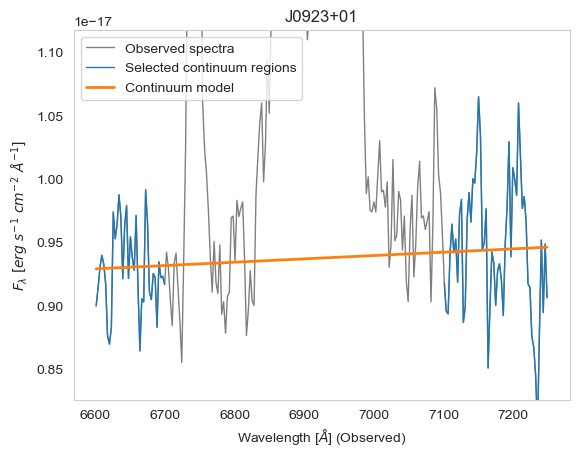

In [5]:
# Define the regions where to fit the continuum
w1c = 6600 * u.angstrom #segment on the left
w2c = 6700 * u.angstrom
w3c = 7100 * u.angstrom #on the right
w4c = 7250 * u.angstrom

# Fit the continuum and estimate the noise
wlimits_cont = ([w1c,w2c],[w3c,w4c])
mask_cont = (wave > w1c) & (wave < w4c)
poly_cont,noise=fit_continuum(wave,flux,wlimits_cont)

# For plotting the chosen region of continuum
wave_cont = wave[mask_cont]
flux_cont = flux[mask_cont]
flux_cont_model = poly_cont(wave_cont)
mask_cont_blue = (wave > w1c) & (wave < w2c)   
mask_cont_red = (wave > w3c) & (wave < w4c)

sns.set_palette('tab10',8)
xlabel=r"Wavelength [$\AA$] (Observed)"
ylabel='$F_\lambda$ $[erg\ s^{-1}\ cm^{-2}\ \AA^{-1}]$'
plt.plot(wave_cont,flux_cont*norm,linewidth=1,color="gray",label="Observed spectra")
plt.plot(wave[mask_cont_blue],flux[mask_cont_blue]*norm,label='Selected continuum regions',color=sns.color_palette('tab10')[0],linewidth=1)
plt.plot(wave[mask_cont_red],flux[mask_cont_red]*norm,color=sns.color_palette('tab10')[0],linewidth=1)
plt.plot(wave_cont,flux_cont_model*norm,label='Continuum model',color=sns.color_palette('tab10')[1],linewidth=2)
plt.legend()
plt.grid()
plt.ylim(np.median(flux_cont*norm.value)-0.15*np.median(flux_cont*norm.value),np.median(flux_cont*norm.value)+0.15*np.median(flux_cont*norm.value))
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.title(tgt_name)

##### Modeling of the [OIII]5007 emission line

In [6]:
# Define the line region
w1 = 6908 *u.angstrom #below [OIII]5007
w2 = 5070*(1+redshift) *u.angstrom #above [OIII]5007
mask = (wave > w1) & (wave < w2) 

flux_reg = flux[mask] #Flux in the line region
wave_reg = wave[mask] #Line region
cont_reg_model = poly_cont(wave_reg)  #Continuum contribution in the line region
flux_reg_nocont=flux_reg - cont_reg_model #Flux without the continuum

# Define the initial parameters for the model
wave_O3r = 5007*(1+redshift)*u.angstrom   #observed 21090
wave_O3b = 4959*(1+redshift)*u.angstrom   #observed 21090
stddev_n = 5*u.angstrom #sigma
amp_O3r = flux_reg_nocont[np.argmin(abs(wave_reg-wave_O3r))] #flux of the nearest point to the central position of the line (wave_o3)

In [7]:
# Choosing the gaussian components for each emission line
c1 = models.Gaussian1D(amplitude=amp_O3r, mean=wave_O3r, stddev=stddev_n,name='[OIII]5007n1')
c2 = models.Gaussian1D(amplitude=amp_O3r/2, mean=wave_O3r, stddev=2*stddev_n,name='[OIII]5007n2')
c3 = models.Gaussian1D(amplitude=amp_O3r/3, mean=wave_O3r, stddev=3*stddev_n,name='[OIII]5007i')

# Conditions to the gaussian amplitudes
c1.amplitude.bounds=(0,None)
c2.amplitude.bounds=(0,None)
c3.amplitude.bounds=(0,None)

line_combo = c1 + c2 + c3 #Gaussians to fit



Initial parameters of the parametric model [7.62673756e+00 6.94600464e+03 8.72423455e+00 2.24839513e+00
 6.94828007e+03 3.05661063e+00 1.23180137e+00 6.94700592e+03
 1.89416793e+01]


Initial velocities of the non-parametric analysis [6947.60025313 1146.97972022  -30.92385458 -822.49370509  760.64599593
  -44.46262533   -9.94648747]


 -------- 


 Executing simulation
[OIII]5007n1
4.294431190736483e-15 erg / (A cm2 s) 1.0115520689626851 2.4701812038413147e-17 erg / (A cm2 s)
 Center= 6946.06 +/- 0.09
 FWHM= 8.931e+02 km / s +/- 2.068e+01 km / s
 Flux= 4.294e-15 erg / (A cm2 s) +/- 1.742e-16 Angstrom erg / (A cm2 s)
 EW= 171.87 +/- 6.97 Angstrom
 
[OIII]5007n2
4.1818161515179925e-16 erg / (A cm2 s) 1.0116296181232136 2.4701812038413147e-17 erg / (A cm2 s)
 Center= 6948.23 +/- 0.23
 FWHM= 3.074e+02 km / s +/- 3.057e+01 km / s
 Flux= 4.182e-16 erg / (A cm2 s) +/- 4.866e-17 Angstrom erg / (A cm2 s)
 EW= 16.73 +/- 1.95 Angstrom
 
[OIII]5007i
1.3169286327944429e-15 erg / (A cm2 s) 1.01162

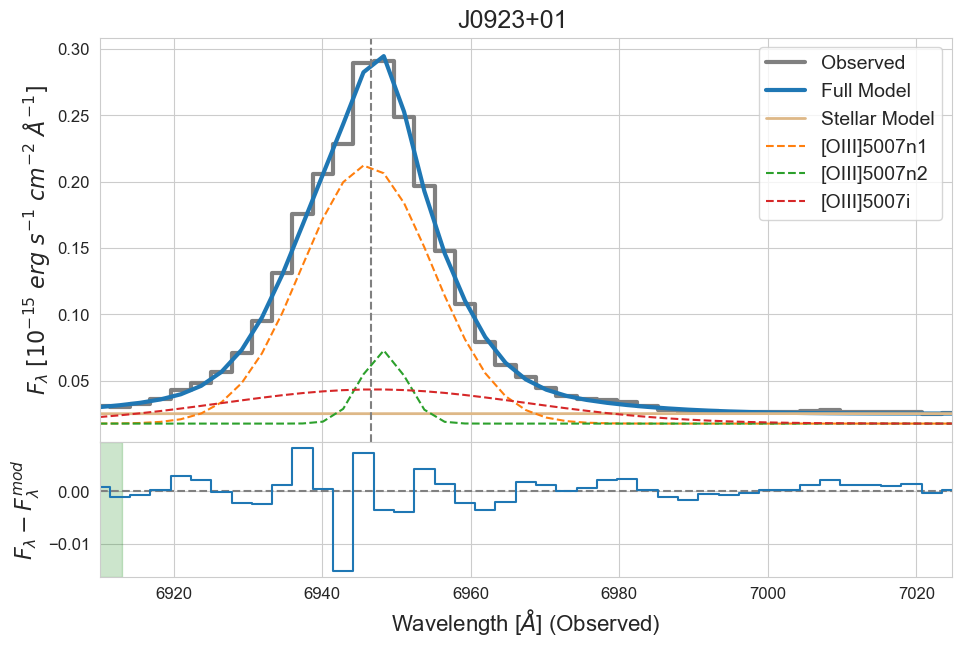

In [8]:
# Perfom the fit to the model
sns.set_palette('tab10',8)
line_combo_fit_5007,line_combo_error_5007,line_tab,chi2_5007,blueshift_5007,eblueshift_5007, nonpar_fit_5007, nonpar_error_5007,\
outflow_fit_5007, outflow_error_5007, outflow_blue_fit_5007, outflow_blue_error_5007, outflow_red_fit_5007, outflow_red_error_5007,\
params_simul_5007, params_simul_nonpar_5007 = perform_fit_plot(wave_reg,flux_reg,cont_reg_model,wave_O3r,wave_O3b,\
          line_combo,noise,Nsimul=1000,plotfile=plotfile,logfile=logfile,flux_norm=norm*(1+redshift)**3,tgt_name=tgt_name)
                    
print('Reduced chi-squared: ',chi2_5007)
print('\n')

#### Simulated distributions

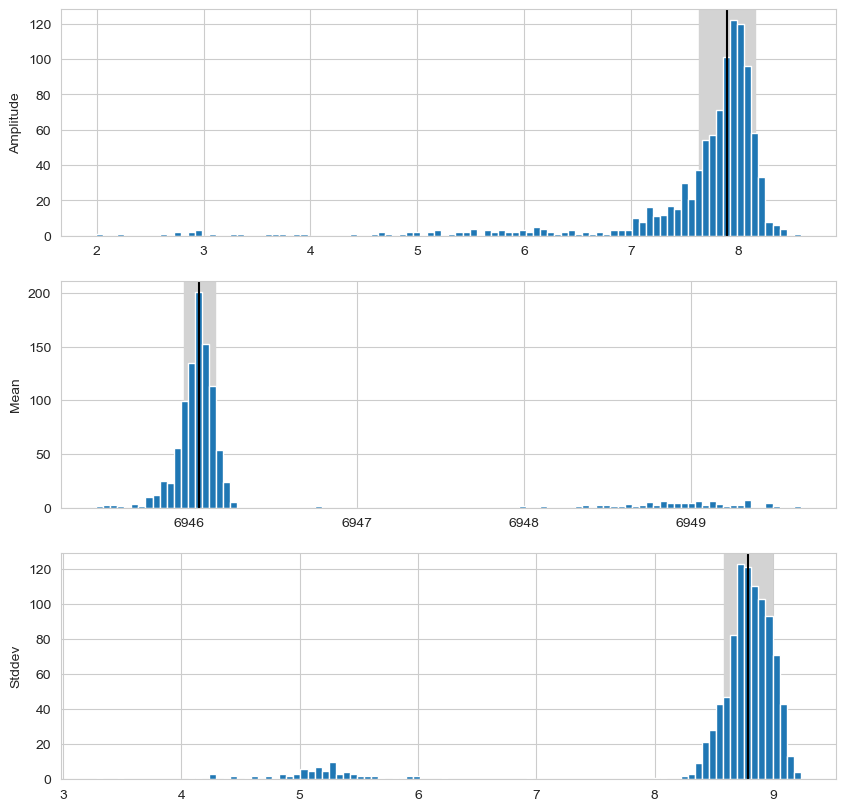

In [9]:
# Checking the simulated normal distributions for the parameters of the first modeled component
f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10))
ax1.axvspan(line_combo_fit_5007.parameters[0]-line_combo_error_5007.parameters[0],line_combo_fit_5007.parameters[0]+line_combo_error_5007.parameters[0],color='lightgrey')
ax1.hist(params_simul_5007[0],bins=100)
ax1.axvline(line_combo_fit_5007.parameters[0],color='black')
ax1.set_ylabel('Amplitude')

ax2.axvspan(line_combo_fit_5007.parameters[1]-line_combo_error_5007.parameters[1],line_combo_fit_5007.parameters[1]+line_combo_error_5007.parameters[1],color='lightgrey')
ax2.hist(params_simul_5007[1],bins=100)
ax2.axvline(line_combo_fit_5007.parameters[1],color='black')
ax2.set_ylabel('Mean')

ax3.axvspan(line_combo_fit_5007.parameters[2]-line_combo_error_5007.parameters[2],line_combo_fit_5007.parameters[2]+line_combo_error_5007.parameters[2],color='lightgrey')
ax3.hist(params_simul_5007[2],bins=100)
ax3.axvline(line_combo_fit_5007.parameters[2],color='black')
ax3.set_ylabel('Stddev')
plt.show()


Text(0, 0.5, 'Asymmetry')

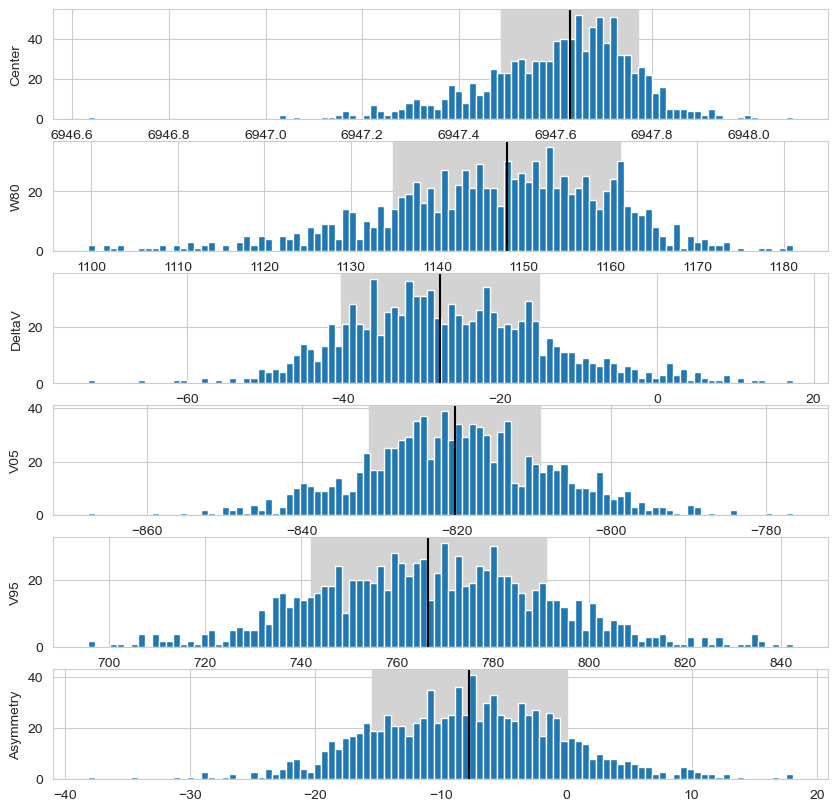

In [10]:
# Checking the simulated normal distributions for the non-parametric velocites
f,(ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,figsize=(10,10))
ax1.axvspan(nonpar_fit_5007[0]-nonpar_error_5007[0],nonpar_fit_5007[0]+nonpar_error_5007[0],color='lightgrey')
ax1.hist(params_simul_nonpar_5007[0],bins=100)
ax1.axvline(nonpar_fit_5007[0],color='black')
ax1.set_ylabel('Center')

ax2.axvspan(nonpar_fit_5007[1]-nonpar_error_5007[1],nonpar_fit_5007[1]+nonpar_error_5007[1],color='lightgrey')
ax2.hist(params_simul_nonpar_5007[1],bins=100)
ax2.axvline(nonpar_fit_5007[1],color='black')
ax2.set_ylabel('W80')

ax3.axvspan(nonpar_fit_5007[2]-nonpar_error_5007[2],nonpar_fit_5007[2]+nonpar_error_5007[2],color='lightgrey')
ax3.hist(params_simul_nonpar_5007[2],bins=100)
ax3.axvline(nonpar_fit_5007[2],color='black')
ax3.set_ylabel('DeltaV')

ax4.axvspan(nonpar_fit_5007[3]-nonpar_error_5007[3],nonpar_fit_5007[3]+nonpar_error_5007[3],color='lightgrey')
ax4.hist(params_simul_nonpar_5007[3],bins=100)
ax4.axvline(nonpar_fit_5007[3],color='black')
ax4.set_ylabel('V05')

ax5.axvspan(nonpar_fit_5007[4]-nonpar_error_5007[4],nonpar_fit_5007[4]+nonpar_error_5007[4],color='lightgrey')
ax5.hist(params_simul_nonpar_5007[4],bins=100)
ax5.axvline(nonpar_fit_5007[4],color='black')
ax5.set_ylabel('V95')

ax6.axvspan(nonpar_fit_5007[6]-nonpar_error_5007[6],nonpar_fit_5007[6]+nonpar_error_5007[6],color='lightgrey')
ax6.hist(params_simul_nonpar_5007[6],bins=100)
ax6.axvline(nonpar_fit_5007[6],color='black')
ax6.set_ylabel('Asymmetry')

#### Parametric model of the [OIII]5007 emission line

In [11]:
table = QTable(names=('LineID', 'Center', 'eCenter','Flux','eFlux','FWHM','eFWHM','EW','eEW'), \
           dtype=('U12','f4', 'f4','f4', 'f4','f4', 'f4','f4','f4'))
table_par_0 = table_add_model(line_combo_fit_5007,table)
table_par_0.add_column(blueshift_5007,name='Blueshift')
table_par_0.add_column(eblueshift_5007,name='eBlueshift')

In [12]:
table_par_0

LineID,Center,eCenter,Flux,eFlux,FWHM,eFWHM,EW,eEW,Blueshift,eBlueshift
str12,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64
[OIII]5007n1,6946.0596,0.094316535,4.294431e-15,1.7420264e-16,893.1393,20.683613,171.86545,6.9716835,-20.698064652990745,4.071887800734942
[OIII]5007n2,6948.234,0.23315354,4.1818162e-16,4.8656703e-17,307.35526,30.574392,16.734571,1.9471183,73.16912156817426,10.065838741823017
[OIII]5007i,6947.036,0.6128295,1.3169286e-15,3.5653936e-16,2071.41,255.26913,52.700153,14.267804,21.458687227736117,26.457430218636823


#### Non parametric analysis of the [OIII]5007 emission line

In [13]:
table_nonpar_0 = QTable(names=('Name', 'Wavepeak', 'Width80','DeltaV','V05','V95','Vmed','Asimetry'),\
           dtype=('U12','f4', 'f4','f4','f4','f4','f4','f4'))
table_nonpar_0.add_row(np.append(tgt_name,nonpar_fit_5007))
table_nonpar_0.add_columns(np.array(nonpar_error_5007,dtype='f4'),indexes=[2,3,4,5,6,7,8],names=('eWavepeak', 'eWidth80','eDeltaV','eV05','eV95','eVmed','eAsimetry'))

In [14]:
table_nonpar_0

Name,Wavepeak,eWavepeak,Width80,eWidth80,DeltaV,eDeltaV,V05,eV05,V95,eV95,Vmed,eVmed,Asimetry,eAsimetry
str12,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0923+01,6947.629,0.14201783,1148.0117,13.089808,-27.677832,12.651309,-820.2436,11.047366,766.54016,24.555513,-44.70895,5.697358,-7.728423,7.795066


### Model for both the [OIII]5007 emission lines



#### Parametric model

In [15]:
# Define the both lines region
w1 = 4910*(1+redshift) *u.angstrom #below [OIII]4959
w2 = 5070*(1+redshift) *u.angstrom #above [OIII]5007
mask = (wave > w1) & (wave < w2) 

flux_reg = flux[mask] #Flux in the line region
wave_reg = wave[mask] #Line region
cont_reg_model = poly_cont(wave_reg)  #Continuum contribution in the line region
flux_reg_nocont=flux_reg - cont_reg_model #Flux without the continuum

In [16]:
# Models for both emission lines
mean_5007=table_par_0['Center'][0]
stddev_5007=table_par_0['FWHM'][0]/(2.999e5*np.sqrt(8*np.log(2))/mean_5007)
amp_5007=table_par_0['Flux'][0]/(np.sqrt(2*np.pi)*stddev_5007*norm*(1+redshift)**3/(u.erg/(u.A*u.s*u.cm*u.cm)))
mean_5007b=table_par_0['Center'][1]
stddev_5007b=table_par_0['FWHM'][1]/(2.999e5*np.sqrt(8*np.log(2))/mean_5007b)
amp_5007b=table_par_0['Flux'][1]/(np.sqrt(2*np.pi)*stddev_5007b*norm*(1+redshift)**3/(u.erg/(u.A*u.s*u.cm*u.cm)))
mean_5007eb=table_par_0['Center'][2]
stddev_5007eb=table_par_0['FWHM'][2]/(2.999e5*np.sqrt(8*np.log(2))/mean_5007eb)
amp_5007eb=table_par_0['Flux'][2]/(np.sqrt(2*np.pi)*stddev_5007eb*norm*(1+redshift)**3/(u.erg/(u.A*u.s*u.cm*u.cm)))

c1 = models.Gaussian1D(amplitude=amp_5007, mean=mean_5007, stddev=stddev_5007,name='[OIII]5007n1')
c2 = models.Gaussian1D(name='[OIII]4959n1')
c3 = models.Gaussian1D(amplitude=amp_5007b, mean=mean_5007b, stddev=stddev_5007b,name='[OIII]5007n2')
c4 = models.Gaussian1D(name='[OIII]4959n2') 
c5 = models.Gaussian1D(amplitude=amp_5007eb, mean=mean_5007eb, stddev=stddev_5007eb,name='[OIII]5007i')
c6 = models.Gaussian1D(name='[OIII]4959i')

# We force the [OIII]5007 line to have the values obtained by the previous fit
c1.stddev.fixed= True
c1.amplitude.fixed= True
c1.mean.fixed = True
c3.stddev.fixed= True
c3.amplitude.fixed= True
c3.mean.fixed = True
c5.stddev.fixed= True
c5.amplitude.fixed= True
c5.mean.fixed = True

#And we force the [OIII]4959 line to verify the relations
c2.mean.tied = tie_center_OIIIn1 #solidarity
c2.stddev.tied = tie_stddevn_OIIIn1 #same kinematic fwhm
c2.amplitude.tied = tie_ampl_OIIIn1 #ratio between the line (amplitude)
c4.mean.tied = tie_center_OIIIn2 #solidarity 
c4.stddev.tied = tie_stddevn_OIIIn2 #same kinematic fwhm
c4.amplitude.tied = tie_ampl_OIIIn2 #ratio between the line (amplitude)
c6.mean.tied = tie_center_OIIIi #solidarity 
c6.stddev.tied = tie_stddevn_OIIIi #same kinematic fwhm
c6.amplitude.tied = tie_ampl_OIIIi #ratio between the line (amplitude)

line_combo = c1 + c2 + c3 + c4 + c5 +c6 #Gaussians to fit

In [ ]:
# Perfom the fit to the model
sns.set_palette('tab10',8)
line_combo_fit, line_combo_error, line_tab, chi2, blueshift, eblueshift, nonpar_fit, nonpar_error,\
outflow_fit, outflow_error, outflow_blue_fit, outflow_blue_error, outflow_red_fit, outflow_red_error,\
params_simul, params_simul_nonpar = perform_fit_plot(wave_reg,flux_reg,cont_reg_model,wave_O3r,wave_O3b,\
          line_combo,noise,Nsimul=1000,plotfile=plotfile,logfile=logfile,flux_norm=norm*(1+redshift)**3,tgt_name=tgt_name)
                    
print('Reduced chi-squared: ',chi2)
print('\n')



Initial parameters of the parametric model [7.89520477e+00 6.94605957e+03 8.78463062e+00 2.63173492e+00
 6.87956287e+03 8.70053273e+00 2.23339384e+00 6.94823389e+03
 3.02399370e+00 7.44464613e-01 6.88171637e+03 2.99504411e+00
 1.04378744e+00 6.94703613e+03 2.03765858e+01 3.47929146e-01
 6.88053009e+03 2.01815147e+01]


Initial velocities of the non-parametric analysis [6947.58062217 1164.22873403  -50.88436488 -866.06699571  764.29826595
  -48.37048576  -22.42017136]


 -------- 


 Executing simulation


In [ ]:
# Table with the fitting parameters for each component of each line
table = QTable(names=('LineID', 'Center', 'eCenter','Flux','eFlux','FWHM','eFWHM','EW','eEW'), \
           dtype=('U12','f4', 'f4','f4', 'f4','f4', 'f4','f4','f4'))
table_par = table_add_model(line_combo_fit,table)

# Blueshift of each component
table_par.add_column(blueshift,name='Blueshift')
table_par.add_column(eblueshift,name='eBlueshift')

# For the error estimation
for i in range(len(table_par['LineID'])):
    if table_par['LineID'][i][:10]=='[OIII]5007':
        for j in range(len(table_par_0['LineID'])):
            if table_par['LineID'][i][-1]==table_par_0['LineID'][j][-1]:
                table_par['eCenter'][i]=5006.843*table_par_0['eCenter'][j]/4958.911
                table_par['eFlux'][i]=3*table_par_0['eFlux'][j]
                table_par['eFWHM'][i]=table_par_0['eFWHM'][j]
                table_par['eEW'][i]=table_par_0['eEW'][j]
                table_par['Blueshift'][i]=table_par_0['Blueshift'][j]
                table_par['eBlueshift'][i]=table_par_0['eBlueshift'][j]
    if table_par['LineID'][i][:10]=='[OIII]4959':
        for j in range(len(table_par_0['LineID'])):
            if table_par['LineID'][i][-1]==table_par_0['LineID'][j][-1]:
                table_par['eCenter'][i]=table_par_0['eCenter'][j]
                table_par['eFlux'][i]=table_par_0['eFlux'][j]
                table_par['eFWHM'][i]=table_par_0['eFWHM'][j]
                table_par['eEW'][i]=table_par_0['eEW'][j]
                table_par['Blueshift'][i]=table_par_0['Blueshift'][j]
                table_par['eBlueshift'][i]=table_par_0['eBlueshift'][j]

# Add name
table_par.add_column(tgt_name,index=0,name='Name')

# Remove non-needed ones
table_par.remove_columns(['Center','eCenter','EW','eEW',])

# Luminosity and flux percentage
table_par.add_column(np.zeros(len(table_par['LineID'])),name='Luminosity')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='eLuminosity')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='Percentage')
table_par.add_column(np.zeros(len(table_par['LineID'])),name='ePercentage')

Flux_4959=[]
Flux_5007=[]
for i in range(len(table_par['LineID'])):
    if table_par['LineID'][i][:10]=='[OIII]5007':
        Flux_5007.append(table_par['Flux'][i])

    if table_par['LineID'][i][:10]=='[OIII]4959':
        Flux_4959.append(table_par['Flux'][i])

for i in range(len(table_par['LineID'])):
    table_par['Luminosity'][i]=table_par['Flux'][i]*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2
    table_par['eLuminosity'][i]=table_par['eFlux'][i]*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2

    if table_par['LineID'][i][:10]=='[OIII]5007':				
        table_par['Percentage'][i]=table_par['Flux'][i]/np.sum(Flux_5007)
        table_par['ePercentage'][i]=table_par['eFlux'][i]/np.sum(Flux_5007)

    if table_par['LineID'][i][:10]=='[OIII]4959':				
        table_par['Percentage'][i]=table_par['Flux'][i]/np.sum(Flux_4959)
        table_par['ePercentage'][i]=table_par['eFlux'][i]/np.sum(Flux_4959)

In [ ]:
table_par

In [ ]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/parametric.txt').to_pandas()
parametric = file.drop(file[file['Name']==tgt_name].index).append(table_par.to_pandas())
ascii.write(QTable.from_pandas(parametric.sort_values('Name')), 'Tables/parametric.txt', format='csv', overwrite = True, formats={'Flux':'%8.2e','eFlux':'%8.2e','FWHM': '%8.1f','eFWHM':'%8.1f','Blueshift': '%8.2f','eBlueshift':'%8.2f','Luminosity': '%8.2e','eLuminosity':'%8.2e','Percentage': '%8.3f','ePercentage':'%8.3f'})

In [ ]:
table_5007 = QTable(names=('Name','LineID','Flux','eFlux','FWHM','eFWHM','Blueshift','eBlueshift','Luminosity','eLuminosity','Percentage','ePercentage'), \
           dtype=('U12','U12','f4', 'f4','f4', 'f4','f4', 'f4','f8','f8','f4', 'f4'))
for i in range(len(table_par['LineID'])):
    if table_par['LineID'][i][:10]=='[OIII]5007':
        table_5007.add_row(table_par[i])

# Save the results in a latex format for the 5007 line
texfile = ascii.read('Tables/parametric.tex',format='latex').to_pandas()
texparametric = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_5007.to_pandas())
ascii.write(QTable.from_pandas(texparametric.sort_values('Name')), 'Tables/parametric.tex', format='latex', overwrite = True, formats={'Flux':'%8.2e','eFlux':'%8.2e','FWHM': '%8.1f','eFWHM':'%8.1f','Blueshift': '%8.2f','eBlueshift':'%8.2f','Luminosity': '%8.3e','eLuminosity':'%8.3e','Percentage': '%8.3f','ePercentage':'%8.3f'})

#### Non-parametric analysis

In [ ]:
perform_nonpar_plot(tgt_name,wave_reg,line_combo_fit,nonpar_fit,flux_norm=norm*(1+redshift)**3)

In [ ]:
table_nonpar = QTable(names=('Name', 'Wavepeak', 'Width80','DeltaV','V05','V95','Vmed','Asimetry'),\
           dtype=('U12','f4', 'f4','f4','f4','f4','f4','f4'))
table_nonpar.add_row(np.append(tgt_name,nonpar_fit))
table_nonpar.add_columns(np.array(nonpar_error_5007,dtype='f4'),indexes=[2,3,4,5,6,7,8],names=('eWavepeak', 'eWidth80','eDeltaV','eV05','eV95','eVmed','eAsimetry'))

In [ ]:
table_nonpar

In [ ]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/nonparametric.txt').to_pandas()
nonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())
ascii.write(QTable.from_pandas(nonparametric.sort_values('Name')), 'Tables/nonparametric.txt', format='csv', overwrite=True, \
            formats={'Name':'','Wavepeak': '%8.2f','eWavepeak': '%8.2f','Width80': '%8.2f','eWidth80': '%8.2f','DeltaV': '%8.2f','eDeltaV': '%8.2f','V05': '%8.2f','eV05': '%8.2f','V95': '%8.2f','eV95': '%8.2f','Vmed': '%8.2f','eVmed': '%8.2f','Asimetry': '%8.2f','eAsimetry': '%8.2f'})

In [ ]:
# Save the results in a latex format
file = ascii.read('Tables/nonparametric.tex').to_pandas()
texnonparametric = file.drop(file[file['Name']==tgt_name].index).append(table_nonpar.to_pandas())
ascii.write(QTable.from_pandas(texnonparametric.sort_values('Name')), 'Tables/nonparametric.tex', format='latex', overwrite=True, \
            formats={'Name':'','Wavepeak': '%8.2f','eWavepeak': '%8.2f','Width80': '%8.2f','eWidth80': '%8.2f','DeltaV': '%8.2f','eDeltaV': '%8.2f','V05': '%8.2f','eV05': '%8.2f','V95': '%8.2f','eV95': '%8.2f','Vmed': '%8.2f','eVmed': '%8.2f','Asimetry': '%8.2f','eAsimetry': '%8.2f'})


# Outflow mass, outflow mass rate and energy rate

## Giovanna's method: outflow line flux

In [ ]:
perform_outflow_plot(tgt_name,wave_reg,line_combo_fit,flux_norm=norm*(1+redshift)**3)

In [ ]:
table_outflow = QTable(names=('Name','Foutflow', 'Voutflow'),\
           dtype=('U12','f8', 'f8'))
table_outflow.add_row(np.append(tgt_name,outflow_fit))
table_outflow.add_columns(np.array(outflow_error_5007,dtype='f8'),indexes=[2,3],names=('eFoutflow', 'eVoutflow'))
table_outflow.add_column(table_outflow['Foutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='Loutflow')
table_outflow.add_column(table_outflow['eFoutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='eLoutflow')

In [ ]:
table_outflow

In [ ]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_giovanna.txt').to_pandas()
outflow_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow.to_pandas())
ascii.write(QTable.from_pandas(outflow_giovanna.sort_values('Name')), 'Tables/outflow_giovanna.txt', format='csv', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_giovanna.tex').to_pandas()
tex_outflow_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_giovanna.sort_values('Name')), 'Tables/outflow_giovanna.tex', format='latex', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

#### Outflow energetics

In [ ]:
outflow_energy,outflow_energy_errors = outflow_energetics_uncertainties(table_outflow,Nsimul=200)

In [ ]:
table_outflow_energy = QTable(names=('Name','LogMof','LogEkin','Rout','LogE.kin','M.of'),\
           dtype=('U12','f4','f4','f4','f4','f4'),\
           descriptions=('',r'[M$_\odot$]','[erg]','[erg $\cdot$ s$^{-1}$]','[kpc]','[M$_\odot$ $\cdot$ yr$^{-1}$]'))
table_outflow_energy.add_row(np.append(tgt_name,outflow_energy))
table_outflow_energy.add_columns(np.array(outflow_energy_errors,dtype='f4'),indexes=[2,3,4,5,6],names=('eLogMof','eLogEkin','eRout','eLogE.kin','eM.of'))

In [ ]:
table_outflow_energy

In [ ]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_energy_giovanna.txt').to_pandas()
outflow_energy_giovanna = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())
ascii.write(QTable.from_pandas(outflow_energy_giovanna.sort_values('Name')), 'Tables/outflow_energy_giovanna.txt', format='csv', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_energy_giovanna.tex').to_pandas()
tex_outflow_energy_giovanna = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_energy_giovanna.sort_values('Name')), 'Tables/outflow_energy_giovanna.tex', format='latex', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

## Non parametric method: v05 and v95

### V05 and v95

In [ ]:
perform_outflow_nonpar_plot(tgt_name,wave_reg,line_combo_fit,nonpar_fit,flux_norm=norm*(1+redshift)**3)

In [ ]:
table_outflow_nonpar = QTable(names=('Name','Foutflow', 'Voutflow'),\
           dtype=('U12','f8', 'f8'))
table_outflow_nonpar.add_row(np.append(tgt_name,outflow_blue_fit))
table_outflow_nonpar.add_row(np.append(tgt_name,outflow_red_fit))

table_outflow_nonpar.add_column(np.array(['Blue','Red' ]),index=1,name=('Outflow'))

table_outflow_nonpar.add_columns(np.array(np.array((outflow_blue_error_5007,outflow_red_error_5007)).T,dtype='f8'),indexes=[2,3],names=('eFoutflow', 'eVoutflow'))
table_outflow_nonpar.add_column(table_outflow_nonpar['Foutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='Loutflow')
table_outflow_nonpar.add_column(table_outflow_nonpar['eFoutflow']*4*np.pi*(cosmo.luminosity_distance(redshift)*3.0857e24)**2/(u.Mpc)**2,name='eLoutflow')

In [ ]:
table_outflow_nonpar

In [ ]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_nonpar.txt').to_pandas()
outflow_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_nonpar.sort_values('Name')), 'Tables/outflow_nonpar.txt', format='csv', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_nonpar.tex').to_pandas()
tex_outflow_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_nonpar.sort_values('Name')), 'Tables/outflow_nonpar.tex', format='latex', overwrite = True,\
            formats={'Foutflow':'%8.2e','eFoutflow':'%8.2e','Voutflow':'%8.2e','eVoutflow':'%8.2e','Loutflow':'%8.2e','eLoutflow':'%8.2e'})

#### Outflow energetics

In [ ]:
outflow_energy_nonpar,outflow_energy_nonpar_errors = outflow_energetics_nonpar_uncertainties(table_outflow_nonpar,200)

In [ ]:
table_outflow_energy_nonpar = QTable(names=('Name','LogMof','LogEkin','Rout','LogE.kin','M.of'),\
           dtype=('U12','f4','f4','f4','f4','f4'),\
           descriptions=('',r'[M$_\odot$]','[erg]','[erg $\cdot$ s$^{-1}$]','[kpc]','[M$_\odot$ $\cdot$ yr$^{-1}$]'))
table_outflow_energy_nonpar.add_row(np.append(tgt_name,outflow_energy_nonpar))
table_outflow_energy_nonpar.add_columns(np.array(outflow_energy_nonpar_errors,dtype='f4'),indexes=[2,3,4,5,6],names=('eLogMof','eLogEkin','eRout','eLogE.kin','eM.of'))

In [ ]:
table_outflow_energy_nonpar

In [ ]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_energy_nonpar.txt').to_pandas()
outflow_energy_nonpar = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())
ascii.write(QTable.from_pandas(outflow_energy_nonpar.sort_values('Name')), 'Tables/outflow_energy_nonpar.txt', format='csv', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_energy_nonpar.tex').to_pandas()
tex_outflow_energy_nonpar = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_nonpar.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_energy_nonpar.sort_values('Name')), 'Tables/outflow_energy_nonpar.tex', format='latex', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

## Parametric method

In [ ]:
table_outflow_par = QTable(names=('Name','Loutflow','eLoutflow', 'Voutflow','eVoutflow',),\
           dtype=('U12','f8', 'f8','f8', 'f8'))
table_outflow_par.add_row([tgt_name,table_par[(table_par['LineID']=='[OIII]5007i')]['Luminosity'],table_par[(table_par['LineID']=='[OIII]5007i')]['eLuminosity'],table_par[(table_par['LineID']=='[OIII]5007i')]['Blueshift'],table_par[(table_par['LineID']=='[OIII]5007i')]['eBlueshift']])

In [ ]:
table_outflow_par

#### Energetics

In [ ]:
outflow_energy_par,outflow_energy_par_errors = outflow_energetics_uncertainties(table_outflow_par,Nsimul=200)

In [ ]:
table_outflow_energy_par = QTable(names=('Name','LogMof','LogEkin','Rout','LogE.kin','M.of'),\
           dtype=('U12','f4','f4','f4','f4','f4'),\
           descriptions=('',r'[M$_\odot$]','[erg]','[erg $\cdot$ s$^{-1}$]','[kpc]','[M$_\odot$ $\cdot$ yr$^{-1}$]'))
table_outflow_energy_par.add_row(np.append(tgt_name,outflow_energy_par))
table_outflow_energy_par.add_columns(np.array(outflow_energy_par_errors,dtype='f4'),indexes=[2,3,4,5,6],names=('eLogMof','eLogEkin','eRout','eLogE.kin','eM.of'))

In [ ]:
table_outflow_energy_par

In [ ]:
# Open existing file and overwrite the data for this target
file = ascii.read('Tables/outflow_energy_par.txt').to_pandas()
outflow_energy_par = file.drop(file[file['Name']==tgt_name].index).append(table_outflow_energy_par.to_pandas())
ascii.write(QTable.from_pandas(outflow_energy_par.sort_values('Name')), 'Tables/outflow_energy_par.txt', format='csv', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

# Open existing file and overwrite the data for this target
texfile = ascii.read('Tables/outflow_energy_par.tex').to_pandas()
tex_outflow_energy_par = texfile.drop(texfile[texfile['Name']==tgt_name].index).append(table_outflow_energy_par.to_pandas())
ascii.write(QTable.from_pandas(tex_outflow_energy_par.sort_values('Name')), 'Tables/outflow_energy_par.tex', format='latex', overwrite = True,\
            formats={'LogMof':'%8.2e','eLogMof':'%8.2e','LogEkin':'%8.2e','eLogEkin':'%8.2e','Rout':'%8.2e','LogE.kin':'%8.2e','eLogE.kin':'%8.2e','M.of':'%8.2e','eM.of':'%8.2e'})

## Comparisson of outflow energetic methods

#### Giovanna's method (1/3 total flux)

In [ ]:
table_outflow_energy

#### Non parametric method (v05 and v95)

In [ ]:
table_outflow_energy_nonpar

#### Parametric methods (broad component)

In [ ]:
table_outflow_energy_par